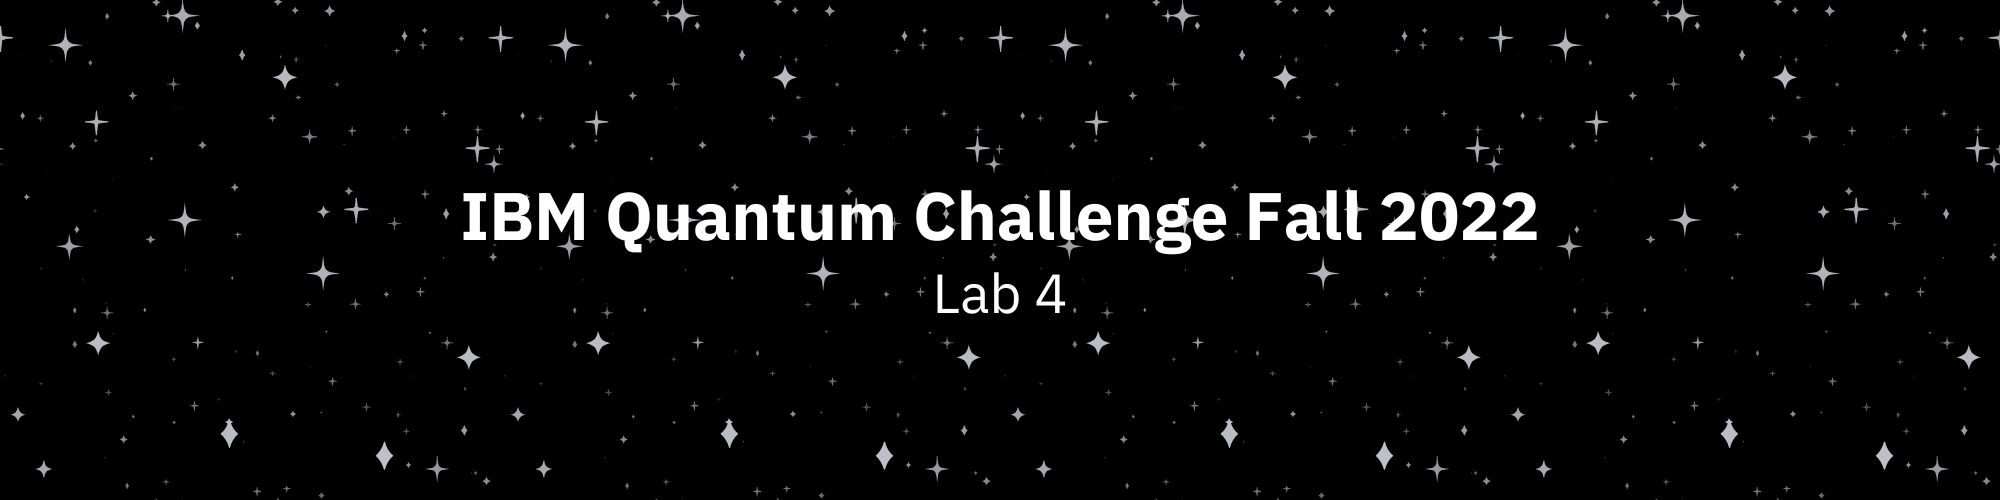

# Final Challenge - Compute <font color='red'>accurate</font> reaction energy of C + C<sub>2</sub>H<sub>2</sub> →C<sub>3</sub>H<sub>2</sub>

||*In this experiment focus was on accuracy not score!*|
|-|-|
|**Author:** |Jacob Cybulski|
|**Date:** |Nov 22, 2022 (20:07 AEST)|
|**Score:** |186563|
|**Calculated<br/>Energy:** |-4.153847690285295 eV (diff=0.11 eV)|
|**Expected<br/>Energy:**|-4.26923078561136 eV|

<br/>

*We shall now proceed to compute the reaction energy, as accurately as possible! As we already saw from the noisy simulation run, basic calculations and idealistic ansatz will return results far from the expected reference result. This also translates to a real quantum backend run.*

**Solve for the <font color='red'>closest reaction energy!</font>**

<a id="final1"></a>

For this challenge, we will provide you a classical quantum chemistry computation reference value as computed by Dr. Yukio Kawashima Sensei.

<b>Note from Sensei: Tips to get a better computation results </b>

- You can try to change the basis set (there are many basis sets found here **[[19]](https://www.basissetexchange.org/))**.
- Here is a good reference about the basis sets **[[20]](http://vergil.chemistry.gatech.edu/courses/chem6485/pdf/basis-sets.pdf)**. 
- You can also try different ansatz. Here is an example of another ansatz **[[21]](https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html)** 

If the convergence does work well on the noisy simulation, explore the following:
- The depth of the ansatz - The ansatz we are passing right now is too deep for current systems
- Specific optimizations with respect to mapping, routing and transpiling for the backend
- Addition of error mitigation or suppression routines


In [2]:
# Upgrade the grader
# !pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git

In [3]:
# Check if the grader has been installed
!pip show qc_grader

Name: qc-grader
Version: 0.13.11
Summary: Grading client for the IBM Quantum Challenge
Home-page: https://quantum-computing.ibm.com/
Author: IBM Quantum Community Team
Author-email: va@us.ibm.com
License: Apache 2.0
Location: /home/jacob/anaconda3/envs/qiskit/lib/python3.8/site-packages
Requires: numpy, requests, qiskit, jsonpickle, networkx, plotly, typeguard, ipycytoscape, jupyterplot
Required-by: 


In [4]:
# Run this cell only once!
# Reset QC_GRADE_ONLY won't affect do_grade_only() 
# In a second run, you must restart the kernel to change behavior

import os
os.environ['QC_GRADE_ONLY'] = 'true'

#check set up
from qc_grader.grader.api import do_grade_only
print(os.getenv('QC_GRADE_ONLY'),do_grade_only())

true True


## Importing Libraries 

First, let's start by importing some libraries. We shall be using one of Qiskit's application modules: Qiskit Nature here for loading chemistry drivers and the necessary functions to help us formulate our problem and solve for the molecule we have at hand.

In [5]:
# Import necessary libraries and packages
import math
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.primitives import Estimator, BackendEstimator, Sampler
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.providers.fake_provider import FakeManilaV2, FakeAthensV2, FakeAthens, FakeLagos
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from qiskit.compiler import transpile
from qiskit.circuit.library import TwoLocal, EfficientSU2

from qiskit.tools.jupyter import *
from qiskit.visualization import *

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP, NELDER_MEAD, POWELL, QNSPSA, ADAM

# Import Qiskit Nature libraries
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD, PUCCD, SUCCD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer, FreezeCoreTransformer
from qiskit_nature.circuit.library import HartreeFock
from qiskit_nature.second_q.circuit.library import HartreeFock as sqHartreeFock
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.algorithms import VQEUCCFactory
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint

# Prototype-zne
# !pip install prototype-zne --quiet

from qiskit_nature.settings import settings
settings.dict_aux_operators = True

## Define backend, estimator and the molecules
The Qiskit Nature driver gives us some properties of the molecule (see also: **[QC schema](https://qiskit.org/documentation/nature/tutorials/08_qcschema.html)**), let's check some out now!

In [6]:
from zne import zne

# Define fake backend
noisy_backend = FakeLagos()
noisy_instance = QuantumInstance(noisy_backend, shots=1024, seed_simulator=2022, seed_transpiler=2022)
ZNEEstimator = zne(BackendEstimator)

In [7]:
# Define geometry
carbon = [["C",[0.0,0.0,0.0]]]

# https://webbook.nist.gov/cgi/cbook.cgi?Name=acetylene&Units=SI
acetylene = [["C", [0.0000,    0.0000,   -0.6025]], 
            ["H",[    0.0000,    0.0000,   -1.6691]], 
            ["C",[    0.0000,    0.0000,    0.6025]], 
            ["H",[    0.0000,    0.0000,    1.6691]]]

# https://atct.anl.gov/Thermochemical%20Data/version%201.122/species/?species_number=442
Cyclopropenylidene =  [["C", [2.2883,    0.6993,    0.3468 ]],
           ["C",[    1.9543,    2.0133,    0.7806]],
           ["C",[    1.0108,    0.9522,    0.6802]],
           ["H",[    3.0291,    0.0000,    0.0000]],
           ["H",[    0.0000,    0.5997,    0.7904]]]

## Building helper functions
Before proceeding further with more VQE problems, it would be convenient to make a reusable custom function that we can call to get problem related items and VQE instances. As an exercise since you built the routine previously, rebuild the functions below to have these helper functions available to be called when needed!

### 1. Helper function for plotting the energy

In [8]:
import matplotlib.pyplot as plt

def plot_graph(energy, real_solution, molecule, color="tab:blue"):
    
    plt.rcParams["font.size"] = 14

    # plot loss and reference value
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.plot(energy, label="Estimator VQE {}".format(molecule),color = color)
    plt.axhline(y=real_solution.real, color="tab:red", ls="--", label="Target")

    plt.legend(loc="best")
    plt.xlabel("Iteration")
    plt.ylabel("Energy [H]")
    plt.title("VQE energy")
    plt.show()

### 2. Helper Functions for constructing problem

Three different approaches (the middle aims at reducing the ansatz size):
1. The original "recommended" approach relying on the UCC factory *(jc_construct_problem_0 / not used here)*
2. The approach allowing custom ansatze, while removing parity and Z2 symmetry *(jc_construct_problem_1 / not used here)*
3. The approach using UCC ansatz but removing parity and Z2 symmetry *(jc_construct_problem_2)*

In [9]:
### The original approach
def jc_construct_problem_0(geometry, charge, multiplicity, basis, num_electrons, num_molecular_orbitals):

    molecule = Molecule(geometry=geometry,
                            charge=charge, 
                            multiplicity=multiplicity) 
    driver = ElectronicStructureMoleculeDriver(molecule, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF) 

    # Run the preliminary quantum chemistry calculation
    properties = driver.run()

    # Set the active space
    active_space_trafo = ActiveSpaceTransformer(
        num_electrons=num_electrons,
        num_molecular_orbitals=num_molecular_orbitals) 
    
    # Now you can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, transformers=[active_space_trafo])

    # The second quantized Hamiltonian of the reduce problem
    second_q_ops_reduced = problem_reduced.second_q_ops()

    mapper = ParityMapper() # This is the example of parity mapping

    # Set the qubit converter with two qubit reduction to reduce the computational cost 
    parity_converter = QubitConverter(mapper, two_qubit_reduction=True)    
    qubit_op = parity_converter.convert(
        second_q_ops_reduced.get('ElectronicEnergy'), 
        num_particles=problem_reduced.num_particles)
   
    # Compute the Hamiltonian in qubit form
    # parity_converter = QubitConverter(mapper, two_qubit_reduction=True, z2symmetry_reduction='auto')    
    # qubit_op = parity_converter.convert(
    #     second_q_ops_reduced.get('ElectronicEnergy'), 
    #     num_particles=problem_reduced.num_particles,
    #     sector_locator=problem_reduced.symmetry_sector_locator)
   
    # Prepare ansatz
    rotation_blocks = ['ry', 'rz']
    entanglement_blocks = 'cx'
    entanglement = 'linear' # 'sca' # 'circular' # 'full' # 'pairwise'
    repetitions = 1 # No repetitions to keep ansatz small
    ansatz = UCC(excitations='sd')
    # ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits, entanglement=entanglement, reps=repetitions) 
    
    # Get reference solution
    vqe_factory = VQEUCCFactory(quantum_instance=StatevectorSimulator(),optimizer=SLSQP(),ansatz=ansatz) 
    solver = GroundStateEigensolver(parity_converter, vqe_factory)    
    real_solution = solver.solve(problem_reduced).total_energies[0]    
    
    ansatz=vqe_factory.ansatz
    
    return ansatz, qubit_op, real_solution, problem_reduced

In [10]:
### This approach allows use of various types of ansatze
def jc_construct_problem_1(geometry, charge, multiplicity, basis, num_electrons, num_molecular_orbitals,
                        entanglement='linear', reps=1, rblocks=['ry', 'rz'], eblocks='cx', skiplast=False,
                        tapvals=None):

    # Define molecule
    molecule = Molecule(geometry=geometry,
                            charge=charge, 
                            multiplicity=multiplicity) 
    driver = ElectronicStructureMoleculeDriver(molecule, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF) 

    # Run the preliminary quantum chemistry calculation
    properties = driver.run()
    
    # Set the active space
    active_space_trafo = ActiveSpaceTransformer(
        num_electrons=num_electrons,
        num_molecular_orbitals=num_molecular_orbitals) 

    # Now you can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, 
            transformers=[active_space_trafo])

    # The second quantized Hamiltonian of the reduce problem
    second_q_ops_reduced = problem_reduced.second_q_ops()

    # Set the mapper to qubits
    mapper_type = 'ParityMapper'

    if mapper_type == 'ParityMapper':
        mapper = ParityMapper()
    elif mapper_type == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mapper_type == 'BravyiKitaevMapper':
        mapper = BravyiKitaevMapper()

    # Two qubit and symmetry reduction to reduce the computational cost 
    parity_converter = QubitConverter(mapper, two_qubit_reduction=True, z2symmetry_reduction='auto')    

    # Compute the Hamitonian in qubit form
    qubit_op = parity_converter.convert(
        second_q_ops_reduced.get('ElectronicEnergy'), 
        num_particles=problem_reduced.num_particles,
        sector_locator=problem_reduced.symmetry_sector_locator)

    # Prepare init state
    num_particles = problem_reduced.num_particles
    num_spin_orbitals = problem_reduced.num_spin_orbitals
    init_state = HartreeFock(num_spin_orbitals, num_particles, parity_converter)
    # init_state.draw(output='mpl')

    # Prepare ansatz    
    
    # entanglement = 'linear' # 'sca' # 'circular' # 'full' # 'pairwise'
    # repetitions = 1 # No repetitions to keep ansatz small
    # ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    # ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    # ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state, reps=1)
    # ansatz = RealAmplitudes(num_qubits=qubit_op.num_qubits, entanglement=entanglement, reps=repetitions)
    # ansatz = UCC(excitations='sd')
    # ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits, entanglement=entanglement, reps=reps) 
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks = rblocks, entanglement_blocks = eblocks, 
                      entanglement=entanglement, reps=reps, skip_final_rotation_layer=skiplast)
    ansatz.compose(init_state, front=True, inplace=True)   
    
    # Get reference solution for UCC ansatze
    # vqe_factory = VQEUCCFactory(quantum_instance=StatevectorSimulator(),optimizer=SLSQP(),ansatz=ansatz) 
    # solver = GroundStateEigensolver(parity_converter, vqe_factory)    
    # real_solution = solver.solve(problem_reduced).total_energies[0]    
    # ansatz=vqe_factory.ansatz
    
    # Get reference solution for custom ansatze
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(parity_converter, solver)
    solver_result = calc.solve(problem_reduced)
    real_solution = np.real(solver_result.eigenenergies[0])

    return ansatz, qubit_op, real_solution, problem_reduced

In [11]:
def jc_construct_problem_2(geometry, charge, multiplicity, basis, num_electrons, num_molecular_orbitals,
                        entanglement='linear', reps=1, rblocks=['ry', 'rz'], eblocks='cx', skiplast=False,
                        tapvals=None):

    molecule = Molecule(geometry=geometry,
                            charge=charge, 
                            multiplicity=multiplicity) 
    driver = ElectronicStructureMoleculeDriver(molecule, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF) 

    # Set the active space
    active_space_trafo = ActiveSpaceTransformer(
        num_electrons=num_electrons,
        num_molecular_orbitals=num_molecular_orbitals) 

    # Now you can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, transformers=[active_space_trafo])

    # The second quantized Hamiltonian of the reduce problem
    second_q_ops_reduced = problem_reduced.second_q_ops()

    # Set the mapper to qubits
    mapper_type = 'ParityMapper'

    if mapper_type == 'ParityMapper':
        mapper = ParityMapper()
    elif mapper_type == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mapper_type == 'BravyiKitaevMapper':
        mapper = BravyiKitaevMapper()

    # Two qubit and symmetry reduction to reduce the computational cost 
    parity_converter = QubitConverter(mapper, two_qubit_reduction=True, z2symmetry_reduction='auto')    

    # Compute the Hamiltonian in qubit form
    qubit_op = parity_converter.convert(
        second_q_ops_reduced.get('ElectronicEnergy'), 
        num_particles=problem_reduced.num_particles,
        sector_locator=problem_reduced.symmetry_sector_locator)
   
    # Prepare ansatz
    ansatz = UCC(excitations='sd', qubit_converter=parity_converter)
    
    # Get reference solution
    vqe_factory = VQEUCCFactory(quantum_instance=StatevectorSimulator(),optimizer=SLSQP(),ansatz=ansatz) 
    # solver = GroundStateEigensolver(
    #     parity_converter, vqe_factory)    
    # real_solution = solver.solve(problem_reduced).total_energies[0]    
    
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(parity_converter, vqe_factory)
    solver_result = calc.solve(problem_reduced)
    real_solution = np.real(solver_result.eigenenergies[0])

    ansatz=vqe_factory.ansatz
    
    # Solver result returned for testing
    return ansatz, qubit_op, real_solution, problem_reduced, solver_result

### 3. Helper function for Running VQE

Two different approaches:
1. The original "recommended" approach, very slow *(jc_custom_estimator_vqe_0 / not used here)*
2. An alternative approach, relying on VQE directly *(jc_custom_estimator_vqe)*

In [12]:
from qiskit.algorithms import VQE as aVQE
from qiskit.algorithms import MinimumEigensolverResult as aMinimumEigensolverResult

### The original approach to running VQE
### - One of its issues is that it creates very large ansatze (based on observables)
def jc_custom_estimator_vqe_0(estimator, ansatz, ops, problem_reduced, optimizer = None, initial_point=None):

    # Define convergence list
    convergence = []

    # Keep track of jobs (Do-not-modify)
    job_list = []

    # Define evaluate_expectation function
    def evaluate_expectation(x):
        x = list(x)

        # Define estimator run parameters
        job = estimator.run(circuits=[ansatz], 
                            observables=[ops], 
                            parameter_values=[x])
        results = job.result().values[0]
        job_list.append(job)

        # Pass results back to callback function
        return np.real(results)

    # Call back function
    def callback(x,fx,ax,tx,nx):
        # Callback function to get a view on internal states and statistics of the optimizer for visualization
        convergence.append(evaluate_expectation(fx))

    np.random.seed(10)

    # Define initial point. We shall define a random point here based on the number of parameters in our ansatz
    if initial_point is None:
        initial_point = np.random.random(ansatz.num_parameters)

    # Define optimizer and pass callback function
    if optimizer == None:
        optimizer = SPSA(maxiter=50, callback=callback)

    # Define minimize function
    result =  optimizer.minimize(evaluate_expectation, x0=initial_point)

    vqe_interpret = []
    for i in range(len(convergence)):
        sol = aMinimumEigensolverResult()
        sol.eigenvalue = convergence[i]
        sol = problem_reduced.interpret(sol).total_energies[0]
        vqe_interpret.append(sol)

    return vqe_interpret, job_list, result

### Need an extra function to interpret the result 
### - Used when non-SPSA optimiser is used 
def custom_interpret(result, problem_reduced):
    sol = aMinimumEigensolverResult()
    sol.eigenvalue = result.fun
    sol = problem_reduced_cy.interpret(sol).total_energies[0]
    return np.real(sol)

In [13]:
### This approach allows using of any non-UCC ansatze
### and various types of optimisers, running on noisy estimators
### - Note that observables are used for eigensolver testing
from qiskit.algorithms.minimum_eigensolvers import VQE as meVQE
from qiskit.algorithms.minimum_eigensolvers import MinimumEigensolverResult as meMinimumEigensolverResult

def jc_custom_estimator_vqe(estimator, ansatz, ops, problem_reduced, optimizer, initial_point=None):

    # Print and save the data in lists
    def callback(eval_count, parameters, mean, std):  
        # Overwrites the same line when printing
        display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
        clear_output(wait=True)
        counts.append(eval_count)
        values.append(mean)
        params.append(parameters)
        deviation.append(std)

    counts = []
    values = []
    params = []
    deviation = []

    # Set initial parameters of the ansatz, which is a fixed small displacement 
    # So all elements start from a similar starting point
    
    # We are running a local Estimator so no options
    # options = Options(simulator={"seed_simulator": 42},resilience_level=0) 

    if initial_point == None:
        try:
            initial_point = [0.01] * len(ansatz.ordered_parameters)
        except:
            initial_point = [0.01] * ansatz.num_parameters

    # Set up the VQE minimum eigenvalue solver
    # and test on various observables
    vqe = meVQE(estimator,
                  ansatz,
                  optimizer=optimizer,
                  callback=callback,
                  initial_point=initial_point)      
    result = vqe.compute_minimum_eigenvalue(ops)

    return values, [], result

### Need an extra function to interpret the result 
### - Used when non-SPSA optimiser is used 
def jc_custom_interpret(result, problem_reduced):
    sol = meMinimumEigensolverResult()
    sol.eigenvalue = result.optimal_value
    sol = problem_reduced.interpret(sol).total_energies[0]
    return np.real(sol)

<a id="experiments"></a>

<div class="alert alert-block alert-success">
<h1>Experiments</h1> 
</div>

### ZNE Setup

Note that initially ZNE experiments were not encouraging. However, later on it was found out that ZNE is an excellent tool to deal with optimisation sensitivity to measurement random effects and noise. Also initially it was thought that larger steps between factors would be more effective. However, later experiments showed that a greater range of factors has a better smoothing effect on the optimisation process. The adopted noise factors were: [1, 2, 3, 4, 5, 6, 7, 8, 9].

In [14]:
from zne import ZNEStrategy
from zne.extrapolation import PolynomialExtrapolator, LinearExtrapolator
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier

# Define Extrapolator
extrapolator = PolynomialExtrapolator(degree=2)

# Define Amplifier
noise_amplifier = LocalFoldingAmplifier() # gates_to_fold=2) 

# Define strategy
zne_strategy = ZNEStrategy(
    noise_factors=[1, 2, 3, 4, 5, 6, 7, 8, 9],
    noise_amplifier = noise_amplifier,
    extrapolator=extrapolator
)

## Considered experimental options

- During ansatz creation, different hamiltonian to qubit mappers were tested (see above), the **parity_mapper** was the most effective reduction of the number of qubits, i.e. both two_qubit_reduction and z2symmetry_reduction.
- Several molecule bases were considered, unexpectedly using **aug-ccpvdz**, allowed creation of a 3-qubit ansatz for Acetylene (rather than 5-quits).
- Different different ansatz types were evaluated. While the small custom ansatze were very effective in reducing the score, the best energy prediction was achieved with **UCC** ansatz, which already included **Hartree-Fock initial state**.
- The ansatz initial state was defined to match the ansatz type, for UCC ansatz **Hartree-Fock initial point** was used.
- Variety of different optimisers were experimented with. Eventually, a non-gradient optimiser **COBYLA** was adopted, which was also the fastest.

In [15]:
# optimizer_cy = COBYLA(maxiter=30)
# optimizer_cy = NELDER_MEAD(maxiter=20)
# optimizer_cy = POWELL(maxiter=20)
# optimizer_cy = SPSA(maxiter=10)
# optimizer_cy = ADAM(maxiter=500, amsgrad=True, lr=0.01, tol=0.0000001)
# fidelity = QNSPSA.get_fidelity(ansatz_cy, StatevectorSimulator(), expectation=PauliExpectation())
# optimizer_cy = QNSPSA(fidelity, maxiter=500, learning_rate=0.01, perturbation=0.2)

## Experiments with Cyclopropenylidene

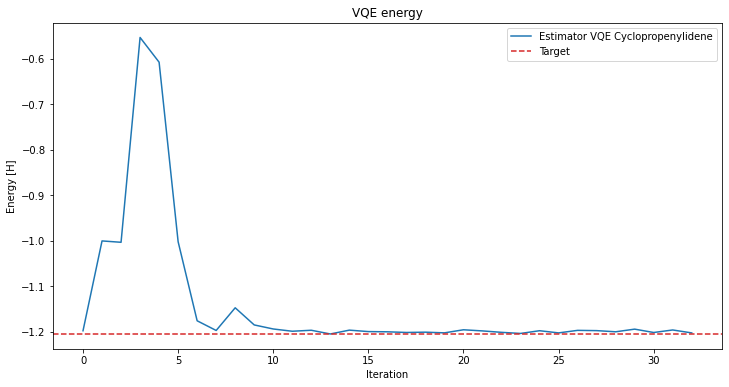

No of qubits: 2
Ref solution:
 -1.2045625177612747


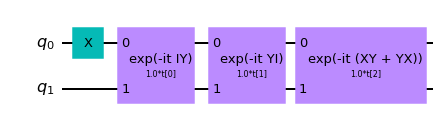



Result
 {   'aux_operators_evaluated': None,
    'cost_function_evals': 33,
    'eigenvalue': -1.2022305166404015,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f3744f513a0>,
    'optimal_parameters': {   ParameterVectorElement(t[0]): 0.06204719726502578,
                              ParameterVectorElement(t[1]): -0.015851557516852518,
                              ParameterVectorElement(t[2]): 0.007750894707725212},
    'optimal_point': array([ 0.0620472 , -0.01585156,  0.00775089]),
    'optimal_value': -1.2022305166404015,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7f3744f59400>,
    'optimizer_time': 163.61983108520508}
CPU times: user 4min 55s, sys: 2min 56s, total: 7min 52s
Wall time: 2min 54s


In [16]:
%%time
algorithm_globals.random_seed = 2022

### Prep the molecule, bases= # aug-ccpvdz # cc-pVDZ # 6-31G** # sto3g
ansatz_cy, ops_cy, real_solution_cy, problem_reduced_cy, _ = jc_construct_problem_2(
    geometry=Cyclopropenylidene, charge=0, multiplicity=1, basis="aug-ccpvdz", num_electrons=2, num_molecular_orbitals=2)

### Find best energy
algorithm_globals.random_seed = 2022

### Select initial point
# init_params_cy = [0.01] * ansatz_cy.num_parameters
hf_initial_point = HFInitialPoint()
hf_initial_point.ansatz = ansatz_cy
init_params_cy = list(hf_initial_point.to_numpy_array())

### Select an optimiser
optimizer_cy = COBYLA(maxiter=300) # (TwoLocal, rep=1, ref=-1.134)(iter=30, opt=-1.127)

### Transpile the ansatz
ansatz_opt_cy = transpile(ansatz_cy, basis_gates=['cx', 'u3'], 
                          backend_properties=noisy_backend.properties(),
                          seed_transpiler=2022, 
                          optimization_level=3)

### Set the estimator and VQE estimate
# estimator_cy = BackendEstimator(backend=StatevectorSimulator())
# estimator_cy = BackendEstimator(backend=noisy_backend)
estimator_cy = ZNEEstimator(backend=noisy_backend, zne_strategy=zne_strategy)
Energy_cy, job_list_cy, result_cy = jc_custom_estimator_vqe(
    estimator_cy, ansatz=ansatz_opt_cy, ops=ops_cy, problem_reduced=problem_reduced_cy,
    optimizer = optimizer_cy, initial_point=init_params_cy)

### Plot the graph
plot_graph(Energy_cy, real_solution_cy, "Cyclopropenylidene")
print('No of qubits:', ops_cy.num_qubits)
print('Ref solution:\n', real_solution_cy)
display(ansatz_cy.decompose().draw())
print('\n\nResult\n', result_cy)

## Experiments with Carbon

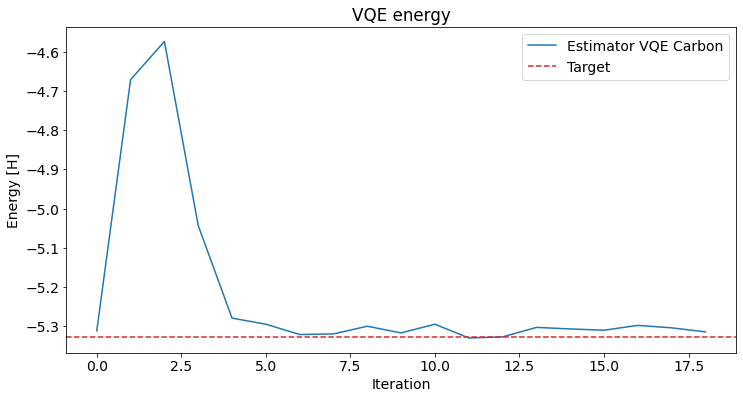

No of qubits: 3
Ref solution:
 -5.327610266355471


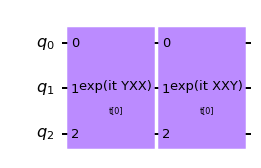



Result
 {   'aux_operators_evaluated': None,
    'cost_function_evals': 19,
    'eigenvalue': -5.314814334652996,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f379f86cbe0>,
    'optimal_parameters': {ParameterVectorElement(t[0]): 0.05869375},
    'optimal_point': array([0.05869375]),
    'optimal_value': -5.314814334652996,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7f379ec3cf40>,
    'optimizer_time': 92.9397783279419}
CPU times: user 2min 25s, sys: 1min 37s, total: 4min 2s
Wall time: 1min 35s


In [17]:
%%time

algorithm_globals.random_seed = 2022

### Prep the molecule, bases= # aug-ccpvdz # cc-pVDZ # 6-31G** # sto3g
ansatz_c, ops_c, real_solution_c, problem_reduced_c, _ = jc_construct_problem_2(
    geometry=carbon, charge=0, multiplicity=3, basis="aug-ccpvdz", num_electrons=4, num_molecular_orbitals=4)
print('No of qubits:', ops_c.num_qubits)
print('Ref solution:\n', real_solution_c)

### Find best energy
algorithm_globals.random_seed = 2022

### Select the initial point
# init_params_c = [0.001] * ansatz_c.num_parameters
# init_params_c = list(np.random.random(ansatz_c.num_parameters))
hf_initial_point = HFInitialPoint()
hf_initial_point.ansatz = ansatz_c
init_params_c = list(hf_initial_point.to_numpy_array())

### Select the optimiser
# sampler = Sampler()
# fidelity = QNSPSA.get_fidelity(ansatz_ac, StatevectorSimulator(), expectation=PauliExpectation())
# optimizer_c = QNSPSA(fidelity, maxiter=500, learning_rate=0.01, perturbation=0.2)
# optimizer_c = POWELL(maxiter=100, xtol=0.001)
# optimizer_c = ADAM(maxiter=500, amsgrad=True, lr=0.01, tol=0.0000001)
# optimizer_c = SLSQP(maxiter=500, tol=0.999, disp=True)
optimizer_c = COBYLA(maxiter=500) # (rep=1, ref=-5.232)(iter=50, opt=-4.993)

### Transpile the ansatz
ansatz_opt_c = transpile(ansatz_c, basis_gates=['cx', 'u3'], seed_transpiler=42, optimization_level=3)

### Select the estimator and VQE estimate
# estimator_c = BackendEstimator(backend=StatevectorSimulator())
# estimator_c = BackendEstimator(backend=noisy_backend)
estimator_c = ZNEEstimator(backend=noisy_backend, zne_strategy=zne_strategy)
Energy_c, job_list_c, result_c = jc_custom_estimator_vqe(
    estimator_c, ansatz=ansatz_opt_c, ops=ops_c, problem_reduced=problem_reduced_c,
    optimizer = optimizer_c, initial_point=init_params_c)

### Plot the graph
plot_graph(Energy_c, real_solution_c, "Carbon")
print('No of qubits:', ops_c.num_qubits)
print('Ref solution:\n', real_solution_c)
display(ansatz_c.decompose().decompose().draw())
print('\n\nResult\n', result_c)

## Experiments with Acetylene

In [18]:
%%time

algorithm_globals.random_seed = 2022

### Prep the molecule, bases= # aug-ccpvdz # cc-pVDZ # 6-31G** # sto3g
ansatz_ac, ops_ac, real_solution_ac, problem_reduced_ac, _ = jc_construct_problem_2(
    geometry=acetylene, charge=0, multiplicity=1, basis="aug-ccpvdz", num_electrons=4, num_molecular_orbitals=4)

# Alternative molecule prep investigated
# ansatz_ac, ops_ac, real_solution_ac, problem_reduced_ac = jc_construct_problem_1(
#     geometry=acetylene, charge=0, multiplicity=1, basis="6-31G**", num_electrons=4, num_molecular_orbitals=4,
#     entanglement='circular', reps=1, rblocks=['rx', 'ry', 'rz'], skiplast=True)
print('No of qubits:', ops_ac.num_qubits)
print('Ref solution:\n', real_solution_ac)

### Find best energy
algorithm_globals.random_seed = 2022

### Select the initial point
# Find initial point
# init_params_ac = list(hf_initial_point.to_numpy_array())
# init_params_ac = list(np.random.random(ansatz_ac.num_parameters))
# init_params_ac = [0.01] * ansatz_ac.num_parameters
# init_params_ac = [0.0001] * ansatz_ac.num_parameters
hf_initial_point = HFInitialPoint()
hf_initial_point.ansatz = ansatz_ac
init_params_ac = list(hf_initial_point.to_numpy_array())

### Transpile the ansatz
ansatz_opt_ac = transpile(ansatz_ac, basis_gates=['cx', 'u3'], seed_transpiler=42, optimization_level=3)

### Select the optimiser
# sampler = Sampler()
# fidelity = QNSPSA.get_fidelity(ansatz_ac, noisy_backend, expectation=PauliExpectation())
# optimizer_ac = QNSPSA(fidelity, maxiter=2000, learning_rate=0.01, perturbation=0.2)
# optimizer_ac = SLSQP(maxiter=100)
# optimizer_ac = ADAM(maxiter=500, amsgrad=True, lr=0.001, tol=0.00001)
optimizer_ac = COBYLA(maxiter=500) # (rep=1, ent=circular ref=-4.409)(iter=50, opt=-3.851)(iter=100, opt=-3.951)

### Select the optimiser
# estimator_ac = BackendEstimator(backend=StatevectorSimulator())
estimator_ac = ZNEEstimator(backend=noisy_backend, zne_strategy=zne_strategy)
# estimator_ac = BackendEstimator(backend=noisy_backend)

No of qubits: 3
Ref solution:
 -4.280824888214528
CPU times: user 1min, sys: 8.21 s, total: 1min 8s
Wall time: 6.25 s


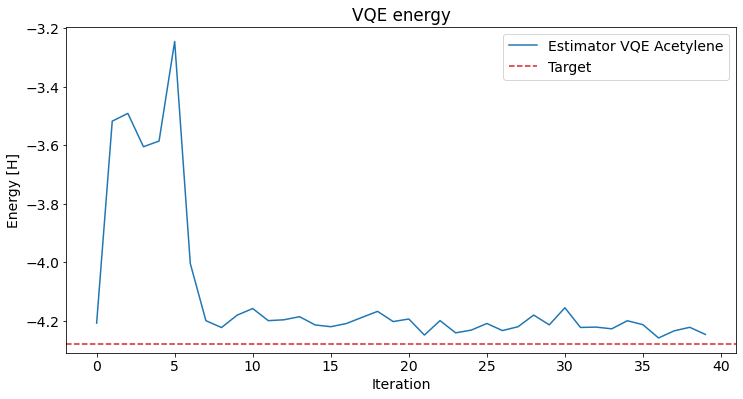

No of qubits: 3
Ref solution:
 -4.280824888214528


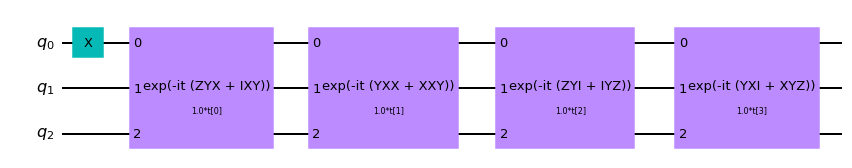



Result
 {   'aux_operators_evaluated': None,
    'cost_function_evals': 40,
    'eigenvalue': -4.247499124451475,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f379e5d8040>,
    'optimal_parameters': {   ParameterVectorElement(t[2]): -0.0932347673006309,
                              ParameterVectorElement(t[3]): 0.001969015819811588,
                              ParameterVectorElement(t[1]): 0.08273356893842686,
                              ParameterVectorElement(t[0]): 0.0007365315285354252},
    'optimal_point': array([ 0.00073653,  0.08273357, -0.09323477,  0.00196902]),
    'optimal_value': -4.247499124451475,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7f379e59d880>,
    'optimizer_time': 398.5190119743347}


In [19]:
### VQE optimise
Energy_ac, job_list_ac, result_ac = jc_custom_estimator_vqe(
    estimator_ac, ansatz=ansatz_opt_ac, ops=ops_ac, problem_reduced=problem_reduced_ac,
    optimizer = optimizer_ac, initial_point=init_params_ac)

### Plot the graph
plot_graph(Energy_ac, real_solution_ac, "Acetylene")
print('No of qubits:', ops_ac.num_qubits)
print('Ref solution:\n', real_solution_ac)
display(ansatz_ac.decompose().draw())
print('\n\nResult\n', result_ac)
# print('\n\nOps\n', ops_ac)

--------

<div class="alert alert-block alert-info">
    <b>Reference Value</b>
    
**Considering difficulties in training the Acytelene ansatze and their sensitivity to small fluctuations in noise or random effects, without ZNE noise mitigation result would vary between -25 eV and -9 eV. With the application of ZNE strategy, the optimisation was very consistent and its curve smooth. The result would vary minimally around -4.15 eV.**
    
- Chemistry engine: Pyscf, version 2.0.1
- Python version: 3.9.12
- Computation options used: 
    - method: CCSD
    - basis: cc-pVDZ

    
**Expected Reaction energy: -4.26923078561136 eV**

</div>

In [21]:
ansatz_list = [ansatz_opt_cy, ansatz_opt_c, ansatz_opt_ac] # List of ansatz circuits
ops_list = [ops_cy, ops_c, ops_ac]
problem_reduced_list = [problem_reduced_cy,  problem_reduced_c,  problem_reduced_ac]
initial_point_list = [init_params_cy, init_params_c, init_params_ac]
optimizer_list = [optimizer_cy, optimizer_c, optimizer_ac]

In [24]:
## Grade and submit your solution
from qc_grader.challenges.fall_2022 import grade_lab4_final

grade_lab4_final(ansatz_list, ops_list, problem_reduced_list, initial_point_list, optimizer_list, zne_strategy)

Running VQE....... 1
VQE run 1 complete
Converged value for run 1 is: (-114.63184728902587+0j)
Result for run 1: {   'fun': -1.2002186637974934,
    'jac': None,
    'nfev': 43,
    'nit': None,
    'njev': None,
    'x': array([ 0.00221091,  0.02467638, -0.00435905])} 

Running VQE....... 2
VQE run 2 complete
Converged value for run 2 is: (-37.674723643934485+0j)
Result for run 2: {   'fun': -5.31554225502417,
    'jac': None,
    'nfev': 22,
    'nit': None,
    'njev': None,
    'x': array([0.13173594])} 

Running VQE....... 3
VQE run 3 complete
Converged value for run 3 is: (-76.80447375716545+0j)
Result for run 3: {   'fun': -4.25696146598408,
    'jac': None,
    'nfev': 47,
    'nit': None,
    'njev': None,
    'x': array([-0.0187435 ,  0.03124722,  0.05197695,  0.01493404])} 

Grading your answer. Please wait...

Your computed reaction energy: -4.153847690285295 eV

Your total score is 186563

Congratulations 🎉! Your answer is correct.



In [22]:
%%html
<style>
table {float:left}
</style>

## Log for noisy backend FakeLagos and noisy BackEnd estimator
<table>
    <tr>
        <th>Exp</th>
        <th colspan="4">Carbon</th>
        <th colspan="4">Acetylene</th>
        <th colspan="4">Cyclopropenylidene</th>
        <th>Reaction Energy</th>
        <th>Score</th>
        <th>Result</th>
    </tr>
    <tr>
        <td>Exp</td>
        <td>Basis</td>
        <td>Ansatz</td>
        <td>Transpl</td>
        <td>Opt</td>
        <td>Basis</td>
        <td>Ansatz</td>
        <td>Transpl</td>
        <td>Opt</td>
        <td>Basis</td>
        <td>Ansatz</td>
        <td>Transpl</td>
        <td>Opt</td>
        <td>Reaction Energy</td>
        <td>Score</td>
        <td>Result</td>
    </tr>
    <tr>
        <td>1</td>
        <td>ccpvdz</td>
        <td>UCC(sd)</td>
        <td></td>
        <td>SPSA (50)</td>
        <td>ccpvdz</td>
        <td>UCC(sd)</td>
        <td></td>
        <td>SPSA (100)</td>
        <td>sto3g</td>
        <td>UCC(sd)</td>
        <td></td>
        <td>SPSA (50)</td>
        <td>-11.626</td>
        <td>7314570</td>
        <td>Correct</td>
    </tr>
    <tr>
        <td>2</td>
        <td>ccpvdz</td>
        <td>UCC(sd)</td>
        <td>cx+u3, Lv=2</td>
        <td>SPSA (50)</td>
        <td>ccpvdz</td>
        <td>UCC(sd)</td>
        <td>cx+u3, Lv=2</td>
        <td>SPSA (50)</td>
        <td>sto3g</td>
        <td>UCC(sd)</td>
        <td>cx+u3, Lv=2</td>
        <td>SPSA (50)</td>
        <td>-9.580</td>
        <td>5603704</td>
        <td>Correct</td>
    </tr>
    <tr>
        <td>3</td>
        <td>sto3g</td>
        <td>EfficientSU2 (linear,1)</td>
        <td>cx+u3, Lv=3</td>
        <td>COBYLA (50)</td>
        <td>sto3g</td>
        <td>EfficientSU2 (linear,1)</td>
        <td>cx+u3, Lv=3</td>
        <td>COBYLA (100)</td>
        <td>sto3g</td>
        <td>EfficientSU2 (linear,1)</td>
        <td>cx+u3, Lv=3</td>
        <td>COBYLA (50)</td>
        <td>26.568</td>
        <td>1034503</td>
        <td>Correct</td>
    </tr>
    <tr>
        <td>4</td>
        <td>sto3g</td>
        <td>EfficientSU2 (full,1)</td>
        <td>cx+u3, Lv=3</td>
        <td>COBYLA (100)</td>
        <td>sto3g</td>
        <td>EfficientSU2 (circular,1)</td>
        <td>cx+u3, Lv=3</td>
        <td>COBYLA (50)</td>
        <td>sto3g</td>
        <td>EfficientSU2 (linear,1)</td>
        <td>cx+u3, Lv=3</td>
        <td>COBYLA (50)</td>
        <td>-17.827</td>
        <td>270362</td>
        <td>Correct</td>
    </tr>
    <tr>
        <td>5</td>
        <td>sto3g</td>
        <td>TwoLocal (full,1,skip)</td>
        <td>cx+u3, Lv=2</td>
        <td>COBYLA (50)</td>
        <td>sto3g</td>
        <td>TwoLocal (circular,1,skip)</td>
        <td>cx+u3, Lv=2</td>
        <td>COBYLA (50)</td>
        <td>sto3g</td>
        <td>TwoLocal (linear,1,skip)</td>
        <td>cx+u3, Lv=2</td>
        <td>COBYLA (30)</td>
        <td>-27.103</td>
        <td>594833</td>
        <td>Correct</td>
    </tr>
    <tr>
        <td>6</td>
        <td>sto3g</td>
        <td>TwoLocal (full,1,noskip)</td>
        <td>cx+u3, Lv=2</td>
        <td>COBYLA (100)</td>
        <td>sto3g</td>
        <td>TwoLocal (circular,1,noskip)</td>
        <td>cx+u3, Lv=2</td>
        <td>COBYLA (50)</td>
        <td>sto3g</td>
        <td>TwoLocal (linear,1,skip)</td>
        <td>cx+u3, Lv=2</td>
        <td>COBYLA (30)</td>
        <td>-13.924</td>
        <td>162766</td>
        <td>Correct</td>
    </tr>
    <tr>
        <td>7</td>
        <td>sto3g</td>
        <td>TwoLocal (full,1,noskip)</td>
        <td>cx+u3, Lv=2</td>
        <td>COBYLA (100)</td>
        <td>sto3g</td>
        <td>TwoLocal (circular,1,noskip)</td>
        <td>cx+u3, Lv=2</td>
        <td>COBYLA (50)</td>
        <td>sto3g</td>
        <td>TwoLocal (linear,1,skip)</td>
        <td>cx+u3, Lv=2</td>
        <td>COBYLA (30)</td>
        <td>-12.074</td>
        <td>130476</td>
        <td>Correct</td>
    </tr>
    <tr>
        <td>7</td>
        <td>sto3g</td>
        <td>TwoLocal (full,1,noskip)</td>
        <td>cx+u3, Lv=2</td>
        <td>COBYLA (100)</td>
        <td>sto3g</td>
        <td>TwoLocal (circular,1,noskip)</td>
        <td>cx+u3, Lv=2</td>
        <td>COBYLA (50)</td>
        <td>sto3g</td>
        <td>TwoLocal (linear,1,skip)</td>
        <td>cx+u3, Lv=2</td>
        <td>COBYLA (30)</td>
        <td>-12.074</td>
        <td>130476</td>
        <td>Correct</td>
    </tr>
    <tr>
        <td>9</td>
        <td>sto3g</td>
        <td>UCC(sd)</td>
        <td>cx+u3, Lv=2</td>
        <td>COBYLA (50)</td>
        <td>sto3g</td>
        <td>UCC(sd)</td>
        <td>cx+u3, Lv=2</td>
        <td>COBYLA (50)</td>
        <td>sto3g</td>
        <td>TwoLocal (linear,1,skip)</td>
        <td>cx+u3, Lv=2</td>
        <td>COBYLA (50)</td>
        <td>-6.410</td>
        <td>93485</td>
        <td>Correct</td>
    </tr>
    <tr>
        <td>11</td>
        <td>aug-ccpvdz</td>
        <td>UCC(sd)</td>
        <td>cx+u3, Lv=3</td>
        <td>COBYLA (33)+ ZNE(1-7)</td>
        <td>aug-ccpvdz</td>
        <td>UCC(sd)</td>
        <td>cx+u3, Lv=3</td>
        <td>COBYLA (21)+ ZNE(1-7)</td>
        <td>aug-ccpvdz</td>
        <td>UCC(sd)</td>
        <td>cx+u3, Lv=3</td>
        <td>COBYLA (48)+ ZNE(1-7)</td>
        <td>-4.567</td>
        <td>186138</td>
        <td>Correct</td>
    </tr>
    <tr>
        <td>12</td>
        <td>aug-ccpvdz</td>
        <td>UCC(sd)</td>
        <td>cx+u3, Lv=3</td>
        <td>COBYLA (33)+ ZNE(1-9)</td>
        <td>aug-ccpvdz</td>
        <td>UCC(sd)</td>
        <td>cx+u3, Lv=3</td>
        <td>COBYLA (21)+ ZNE(1-9)</td>
        <td>aug-ccpvdz</td>
        <td>UCC(sd)</td>
        <td>cx+u3, Lv=3</td>
        <td>COBYLA (48)+ ZNE(1-9)</td>
        <td>-4.153</td>
        <td>186563</td>
        <td>Correct</td>
    </tr>
</table>


# References
- [1] **[Physics of the Interstellar Medium Lecture Notes: Interstellar Molecules](https://www.astronomy.ohio-state.edu/pogge.1/Ast871/Notes/Molecules.pdf)**
- [2] **[Chemistry and Dynamics in the Interstellar Medium](https://pubs.rsc.org/en/content/chapterhtml/2017/bk9781782627760-00001?isbn=978-1-78262-776-0)**
- [3] **[Interstellar chemistry](https://www.pnas.org/doi/full/10.1073/pnas.0605352103)**
- [4] **[Interstellar $H_3^+$](https://www.pnas.org/doi/10.1073/pnas.0601242103)**
- [5] **[Spectroscopic properties of interstellar molecules: Theory and experiment](https://pubs.rsc.org/en/content/articlelanding/2003/CP/b303753n)**
- [6] **[Cyclopropenylidene (Wikipedia)](https://en.wikipedia.org/wiki/Cyclopropenylidene)**
- [7] **[$H_3^+$: the initiator of interstellar chemistry](https://www.cambridge.org/core/journals/international-journal-of-astrobiology/article/abs/h3-the-initiator-of-interstellar-chemistry/69C0753DDB337E4475416CB6FA3D802D)**
- [8] **[The interstellar chemistry of $C_3H$ and $C_3H_2$ isomers]( https://arxiv.org/ftp/arxiv/papers/1707/1707.07926.pdf)**
- [9] **[PubChem](https://pubchem.ncbi.nlm.nih.gov/)**
- [10] **[NIST Chemistry WebBook, SRD 69](https://webbook.nist.gov/chemistry/form-ser/)**
- [11] **[$H_3^+$: Ab initio calculation of the vibration spectrum](https://aip.scitation.org/doi/abs/10.1063/1.433585)**
- [12] **[Quantum algorithms for electronic structure calculations: particle/hole Hamiltonian and optimized wavefunction expansions](https://arxiv.org/abs/1805.04340)**
- [13] **[A survey of cyclopropenylidene (C3H2) in galactic sources](https://pubmed.ncbi.nlm.nih.gov/11542419/)**
- [14] **[Cyclopropenylidene properties provided by NIST Chemistry WebBook, SRD 69](https://webbook.nist.gov/cgi/cbook.cgi?ID=C16165405&Units=CAL&Mask=3FFF)**
- [15] **[The B 1B1 State of Cyclopropenylidene, c-C3H2](https://pubs.acs.org/doi/10.1021/jz900114r)**
- [16] **[The dipole moment of $C_3H_2$](https://academic.oup.com/mnras/article/227/1/19P/1066005)**
- [17] **[C + C2H2: A Key Reaction in Interstellar Chemistry](https://pubs.acs.org/doi/10.1021/jp020310z)**
- [18] **[Variational Quantum Computation of Excited States](https://arxiv.org/abs/1805.08138)**

# Additional information

<b>Created by:</b> Desiree Vogt-Lee, Sophy Shin, Vishal Bajpe, Yuri Kobayashi

<b>Advisor:</b> Yukio Kawashima, Pedro Rivero

<b>Creative assets by:</b> Radha Pyari Sandhir

<b>IBM Open Science Prize</b>  
Congratulations on making it all the way to the end of The IBM Quantum Challenge Fall 2022! If you’re looking to apply your new-found knowledge further, we encourage you to participate in the IBM Open Science Prize that will be announced later this year. Every year, a new technical challenge at the forefront of quantum computing is posed to the entire world and those who generate the strongest solutions win thousands of dollars in prizes! We hope to see you there!


Version: 1.0

In [23]:
from qiskit.tools.jupyter import *
%qiskit_version_table